In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from feature_engineering import create_sequences
from model import CNNTransformer
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV

import warnings
warnings.filterwarnings("ignore")

In [2]:
data_path = "yearly_pairs_features.csv"
all_data = pd.read_csv(data_path)
all_data.head()

,price_A,price_B,spread,spread_z,spread_vol,halflife,bollinger_pct,rolling_beta,vol_ratio,lead_lag_diff,hedge_ratio,alpha,date,next_day_spread,formation_year,pair
0,140.895584,55.585850,7.654978,1.447035,11.835990,16.276600,0.861759,-0.692500,1.197413,0.005298,2.459785,-3.488607,2019-01-31,9.388391,2019,ACN-MKC
1,141.987534,55.325069,9.388391,1.423423,12.126556,29.038782,0.855856,-0.732236,0.942397,0.001187,2.459785,-3.488607,2019-02-01,12.464680,2019,ACN-MKC
2,143.648346,54.749622,12.464680,1.483217,12.677832,32.588188,0.870804,-0.739383,0.747234,0.018151,2.459785,-3.488607,2019-02-04,9.842575,2019,ACN-MKC
3,144.354904,56.102856,9.842575,1.151456,12.798783,13.387454,0.787864,-0.766190,0.730307,-0.013020,2.459785,-3.488607,2019-02-05,11.498362,2019,ACN-MKC
4,144.208115,55.370037,11.498362,1.156455,12.878855,12.753697,0.789114,-0.771003,0.647869,0.017981,2.459785,-3.488607,2019-02-06,7.812616,2019,ACN-MKC


In [3]:
print("Total Pairs from 2019 - 2023:", len(all_data['pair'].unique()))

Total Pairs from 2019 - 2023: 127


In [4]:
# Convert date column to datetime for sorting
all_data['date'] = pd.to_datetime(all_data['date'])

# Sort by date to ensure chronological order
all_data = all_data.sort_values(['date', 'pair'])
all_data.head()

,price_A,price_B,spread,spread_z,spread_vol,halflife,bollinger_pct,rolling_beta,vol_ratio,lead_lag_diff,hedge_ratio,alpha,date,next_day_spread,formation_year,pair
462,27.908873,168.706680,0.289516,1.540958,1.051513,20.511471,0.885240,0.138478,0.111587,0.026340,0.135780,4.712320,2019-01-31,-0.264061,2019,ACGL-MLM
0,140.895584,55.585850,7.654978,1.447035,11.835990,16.276600,0.861759,-0.692500,1.197413,0.005298,2.459785,-3.488607,2019-01-31,9.388391,2019,ACN-MKC
924,63.368599,29.182611,-0.067946,0.927940,0.915846,1.580292,0.731985,1.550445,1.581816,-0.018082,1.470165,20.533298,2019-01-31,0.584648,2019,AEP-JCI
1848,36.540932,147.809998,1.498924,1.032219,1.755691,2.414783,0.758055,0.164425,0.393112,0.042032,0.265872,-4.256527,2019-01-31,2.163298,2019,AMAT-LULU
3465,69.922798,331.049988,-4.619364,-1.250421,2.022411,1.990838,0.187395,-0.093727,0.099411,-0.130481,0.137319,29.082663,2019-01-31,-5.489638,2019,AME-CHTR


In [5]:
all_data.tail()

,price_A,price_B,spread,spread_z,spread_vol,halflife,bollinger_pct,rolling_beta,vol_ratio,lead_lag_diff,hedge_ratio,alpha,date,next_day_spread,formation_year,pair
26812,76.059998,147.953827,2.954225,1.652381,1.997259,5.483858,0.913095,0.775009,0.494842,0.002572,0.386989,15.849218,2023-12-28,2.633339,2023,HSIC-UPS
29102,77.694641,959.263245,2.472976,1.397539,1.312247,3.016859,0.849385,0.117269,0.088378,0.001052,0.063429,14.376423,2023-12-28,2.104956,2023,IR-TDG
29331,20.597002,230.020203,1.262693,0.248049,0.666065,3.652195,0.562012,0.168423,0.116279,-0.008363,0.072559,2.644268,2023-12-28,0.810318,2023,KIM-NSC
27728,68.308052,41.701099,-3.743761,-0.630051,0.780551,1.889336,0.342487,1.574236,1.539292,0.000498,1.797897,-2.922477,2023-12-28,-3.878914,2023,SCHW-USB
28186,71.717010,30.012131,-0.461472,-1.158284,1.054456,2.352075,0.210429,1.389477,3.392119,-0.015611,1.595027,24.308325,2023-12-28,0.042420,2023,SRE-VICI


In [6]:
all_X_train = []
all_y_train = []
all_X_val = []
all_y_val = []

# Define specific time frames for training and validation
val_year = 2023 # Use the entire 2023 as the validation data

train_data = all_data[all_data["formation_year"] < val_year] # 2019, 2021 and 2022 and training
val_data = all_data[all_data["formation_year"] == val_year] # 2023 as validation

print(train_data.shape)
print(val_data.shape)

(25439, 16)
(3893, 16)


In [7]:
def create_sequences(features: pd.DataFrame, sequence_length: int = 20, target_column = "next_day_spread"):
    """
    Create sequences of features and targets for training.
    
    Parameters:
    -----------
    features : pd.DataFrame
        DataFrame containing all computed features
    sequence_length : int, optional
        Length of each sequence
        
    Returns:
    --------
    np.ndarray, np.ndarray
        Arrays containing sequences of features and targets
    """
    sequences = []
    targets = []
    
    for i in range(len(features) - sequence_length):
        seq = features.iloc[i:i + sequence_length].drop([target_column], axis=1).values
        target = features.iloc[i + sequence_length][target_column]
        sequences.append(seq)
        targets.append(target)
    
    return np.array(sequences), np.array(targets).reshape(-1, 1)

In [8]:
# Length of input sequences
sequence_length = 30 

# Feature columns - exclude date, pair, and target
feature_cols = [col for col in all_data.columns if col not in ['date', 'pair', 'next_day_spread']]

# Init scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features
train_data.loc[:, feature_cols] = feature_scaler.fit_transform(train_data[feature_cols])
val_data.loc[:, feature_cols] = feature_scaler.transform(val_data[feature_cols]) # prevent data leakage, don't fit on val data

# Scale target
train_data.loc[:, 'next_day_spread'] = target_scaler.fit_transform(train_data[['next_day_spread']])
val_data.loc[:, 'next_day_spread'] = target_scaler.transform(val_data[['next_day_spread']])

X_train = np.array(train_data[feature_cols])
y_train = np.array(train_data['next_day_spread'])
X_val = np.array(val_data[feature_cols])
y_val = np.array(val_data['next_day_spread'])

print(train_data.shape, val_data.shape)

(25439, 16) (3893, 16)


In [10]:
# Define the parameter grid for XGBRegressor
param_grid = {
    'n_estimators': [100, 300],                         
    'learning_rate': [0.01, 0.05, 0.1],                 
    'max_depth': [3, 6, 9],                        
    'subsample': [0.6, 0.8, 1.0],                     
    'colsample_bytree': [0.6, 0.8, 1.0],          
    'gamma': [0, 1, 5],                                
    'reg_alpha': [0, 0.1, 1], # L1 regularization
    'reg_lambda': [1, 5, 10], # L2 regularization
}

# Initialize the XGBRegressor
xgb_model = XGBRegressor(
    random_state=42,
    tree_method='hist',
    device='cuda'
)

# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=2,
    n_jobs=1,
)

# Perform the grid search
print("Performing hyperparameter tuning...")
grid_search.fit(X_train, y_train)

# Get the best parameters and the best score
best_params = grid_search.best_params_
best_score = -grid_search.best_score_  # Convert negative MSE to positive
print(f"Best Parameters: {best_params}")
print(f"Best Validation MSE: {best_score:.6f}")

# Train the model with the best parameters
print("Training XGBoost model with best parameters...")
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Evaluate the tuned model on the validation set
print("Evaluating tuned XGBoost model...")
y_val_pred = best_xgb_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Tuned Validation MSE: {val_mse:.6f}")

Performing hyperparameter tuning...
Fitting 3 folds for each of 4374 candidates, totalling 13122 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.6; total time=   0.0s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, n_estimators=100, reg_alpha=0, reg_lambda=1, subsample=0.8; total

In [12]:
print(grid_search.best_params_)

{'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.6}


Evaluating tuned XGBoost model...
Tuned Validation MSE: 0.046751


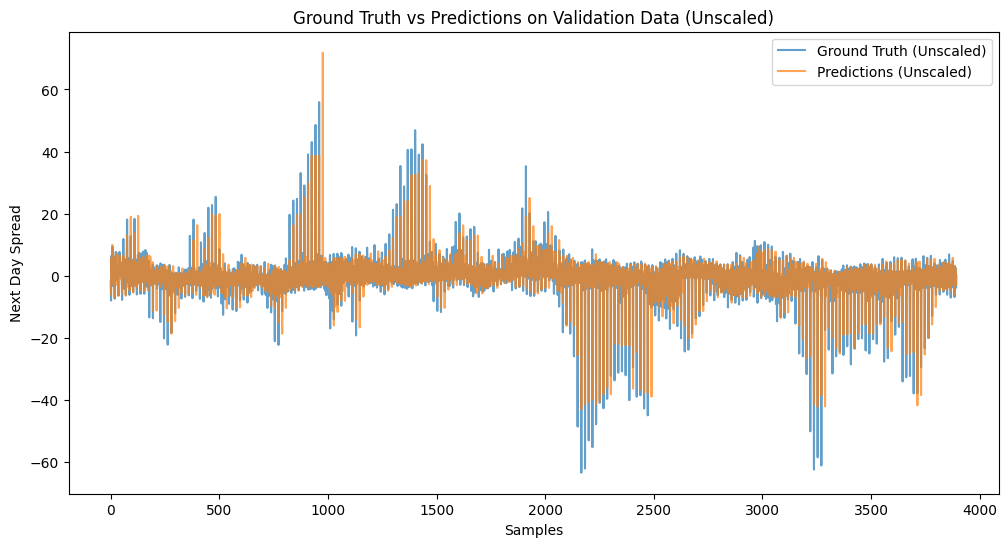

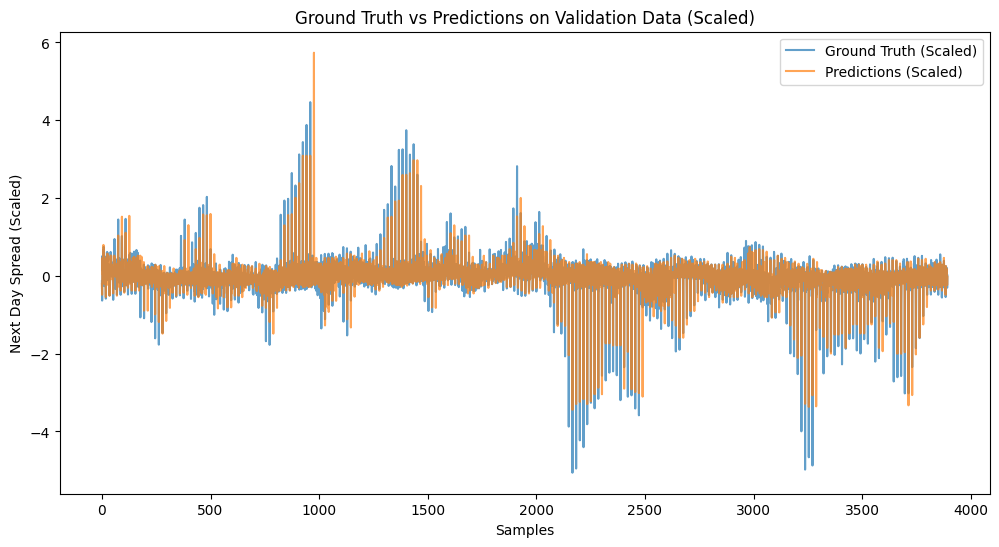

In [14]:
import matplotlib.pyplot as plt

# Train the model with the best parameters
best_xgb_model = grid_search.best_estimator_
best_xgb_model.fit(X_train, y_train)

# Evaluate the tuned model
print("Evaluating tuned XGBoost model...")
y_val_pred = best_xgb_model.predict(X_val)
val_mse = mean_squared_error(y_val, y_val_pred)
print(f"Tuned Validation MSE: {val_mse:.6f}")

# Plot ground truth vs predictions (unscaled)
plt.figure(figsize=(12, 6))
plt.plot(target_scaler.inverse_transform(y_val.reshape(-1, 1)), label="Ground Truth (Unscaled)", alpha=0.7)
plt.plot(target_scaler.inverse_transform(y_val_pred.reshape(-1, 1)), label="Predictions (Unscaled)", alpha=0.7)
plt.title("Ground Truth vs Predictions on Validation Data (Unscaled)")
plt.xlabel("Samples")
plt.ylabel("Next Day Spread")
plt.legend()
plt.show()

# Plot ground truth vs predictions (scaled)
plt.figure(figsize=(12, 6))
plt.plot(y_val, label="Ground Truth (Scaled)", alpha=0.7)
plt.plot(y_val_pred, label="Predictions (Scaled)", alpha=0.7)
plt.title("Ground Truth vs Predictions on Validation Data (Scaled)")
plt.xlabel("Samples")
plt.ylabel("Next Day Spread (Scaled)")
plt.legend()
plt.show()